In [63]:
import os
import requests
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from numpy import savetxt, loadtxt
from tensorflow.keras import Model
from skimage.transform import resize
from tensorflow.keras import Sequential
from tqdm.contrib.concurrent import thread_map
from sklearn.metrics import average_precision_score
from sentence_transformers import SentenceTransformer, util
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions


In [62]:
local_store = "features/"

dataset = {
    "train" : None, 
    "test" : None,
    "val" : None
}

dataset_size = {
    "train": 20523,
    "test": 1000,
    "val": None
}

image_base_url = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"
image_annotation_file_urls = { split: "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/" + split + ".json" for split in dataset.keys() }

In [64]:
for split in dataset.keys():
    dataset[split] = requests.get(image_annotation_file_urls[split], allow_redirects=True).json()[:dataset_size[split]]

In [65]:
image_urls = {}
for split in dataset.keys():
    url_list = []
    for image_data in dataset[split]:
        url_list.append(image_base_url + image_data['image'])
    image_urls[split] = url_list

questions = {}
for split in dataset.keys():
    question_list = []
    for image_data in dataset[split]:
        question_list.append(image_data['question'])
    questions[split] = question_list

In [66]:

inception_resnet = InceptionResNetV2(weights='imagenet')
image_model = Model(inputs=inception_resnet.input, outputs=inception_resnet.layers[-2].output)
transformer = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-tas-b')

In [67]:
def get_features_from_disk(path):
  print("Getting features from disk")
  files = os.listdir(path)
  features = []
  for file in files:
    features.append(loadtxt(os.path.join(path, file), delimiter = ","))
  return np.concatenate(features, axis=0)

def get_batches(huge_list, batch_size = 200, starting_batch = 0):
  return (huge_list[index:index + batch_size] for index in range(starting_batch * batch_size, len(huge_list), batch_size))

def download_image(url):
  return resize(io.imread(url), (299,299))

def extract_features_from_image(image_urls, path, starting_batch = 0, batch_size = 200):
  batch_number = starting_batch
  for url_batch in get_batches(image_urls, batch_size, starting_batch):
    print("Getting images - Batch " + str(batch_number))
    images = np.array(thread_map(download_image, url_batch, max_workers=8, chunksize = 20))
    features = image_model.predict(preprocess_input(images))
    savetxt(os.path.join(path, "features_batch_" + str(batch_number) + ".txt"), features, delimiter=',')
    batch_number += 1
    
def get_image_features(image_urls, split, get_from_disk, starting_batch = 0):
  path = os.path.join(local_store, split, "image_embeddings")
  if not get_from_disk:
    extract_features_from_image(image_urls, path, starting_batch)
  return get_features_from_disk(path)

def extract_embeddings_questions(questions, path):
  embeddings = transformer.encode(questions)
  savetxt(os.path.join(path, "question_embeddings.txt"), embeddings, delimiter=',')

def get_question_features(questions, split, get_from_disk):
  path = os.path.join(local_store, split, "question_embeddings")
  if not get_from_disk:
    extract_embeddings_questions(questions, path)
  return get_features_from_disk(path)

def get_features(split, get_from_disk = False, starting_batch = 0):
  print("Extracting features from image")
  image_features = get_image_features(image_urls[split], split, get_from_disk, starting_batch)
  print("Extracting embeddings from questions")
  question_features = get_question_features(questions[split], split, get_from_disk)
  final_features = np.concatenate((image_features, question_features), axis= 1)
  return final_features

In [70]:
x = {}
x["train"] = get_features("train", True)

Extracting features from image
Getting features from disk
Extracting embeddings from questions
Getting features from disk


In [71]:
x["test"] = get_features("test", True)

Extracting features from image
Getting features from disk
Extracting embeddings from questions
Getting features from disk


In [72]:
x["val"] = get_features("val", True)

Extracting features from image
Getting features from disk
Extracting embeddings from questions
Getting features from disk


In [73]:
y = {}
y['train'] = np.array(list(map(lambda data : data['answerable'], dataset['train'])))
y['val'] = np.array(list(map(lambda data : data['answerable'], dataset['val'])))

In [74]:
input_shape = x['train'].shape[1]
models = []

In [75]:
model = Sequential()
model.add(Input(shape = (input_shape)))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics= ['accuracy'])
models.append(model)

In [76]:
model = Sequential()
model.add(Input(shape = (input_shape)))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics= ['accuracy'])
models.append(model)

In [77]:
model = Sequential()
model.add(Input(shape = (input_shape)))
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics= ['accuracy'])
models.append(model)

In [87]:
for i, model in enumerate(models):
  print("Starting training for model", i + 1)
  model.fit(x['train'],y['train'], validation_data = (x['val'],y['val']),batch_size = 64, epochs = 50)

Starting training for model 1
Epoch 1/50
321/321 [==============================] - 5s 16ms/step - loss: 0.3339 - accuracy: 0.8633 - val_loss: 1.9501 - val_accuracy: 0.7053
Epoch 2/50
321/321 [==============================] - 5s 15ms/step - loss: 0.3672 - accuracy: 0.8629 - val_loss: 2.1408 - val_accuracy: 0.7083
Epoch 3/50
321/321 [==============================] - 5s 16ms/step - loss: 0.3317 - accuracy: 0.8643 - val_loss: 2.3502 - val_accuracy: 0.7099
Epoch 4/50
321/321 [==============================] - 5s 16ms/step - loss: 0.3287 - accuracy: 0.8635 - val_loss: 1.6827 - val_accuracy: 0.6946
Epoch 5/50
321/321 [==============================] - 5s 15ms/step - loss: 0.3376 - accuracy: 0.8670 - val_loss: 1.9261 - val_accuracy: 0.7048
Epoch 6/50
321/321 [==============================] - 5s 16ms/step - loss: 0.3241 - accuracy: 0.8659 - val_loss: 2.6816 - val_accuracy: 0.7034
Epoch 7/50
321/321 [==============================] - 5s 16ms/step - loss: 0.3256 - accuracy: 0.8674 - val_loss:

Loss curves for model 1


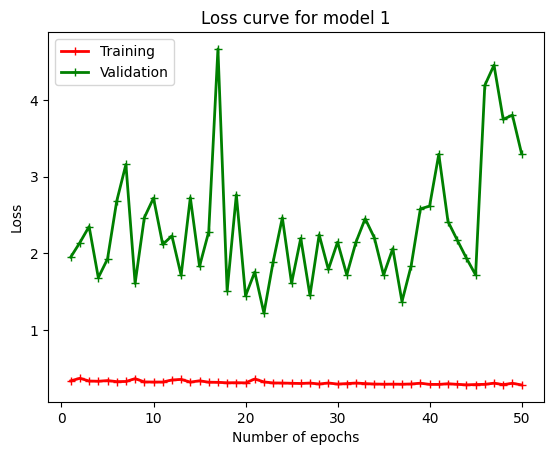

Loss curves for model 2


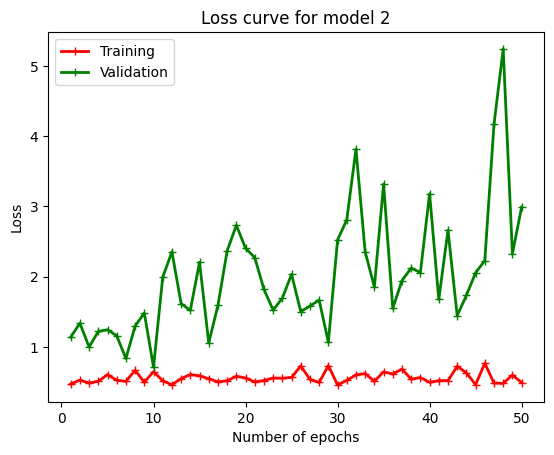

Loss curves for model 3


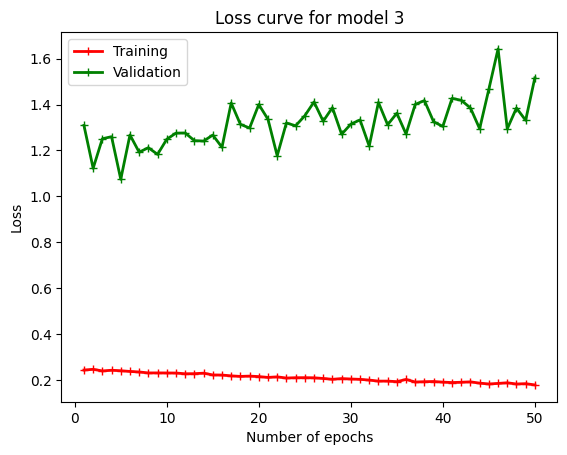

In [88]:
for i, model in enumerate(models):
  print("Loss curves for model", i + 1)
  training_loss = model.history.history['loss']
  validation_loss = model.history.history['val_loss']
  colours = ["r-+","g-+"]
  fig, ax = plt.subplots()
  epochs = list(range(1,len(training_loss) + 1))
  plt.plot(epochs, training_loss, colours[0], linewidth = 2, label='Training Loss')
  plt.plot(epochs, validation_loss, colours[1], linewidth = 2, label='Validation Loss')
  ax.legend(["Training", "Validation"])
  plt.xlabel("Number of epochs")
  plt.ylabel("Loss")
  plt.title("Loss curve for model " + str(i + 1))
  plt.show()

In [83]:
best_model_precision = 0.0
best_model_index = 0
for i, model in enumerate(models):
  training_predictions = model.predict(x["train"])
  validation_predictions = model.predict(x["val"])
  print("Average precision for model", i + 1, "on training data:", average_precision_score(y["train"],training_predictions))
  
  validation_precision = average_precision_score(y["val"],validation_predictions)
  if validation_precision > best_model_precision:
    best_model_precision = validation_precision
    best_model_index = i
  print("Average precision for model", i + 1, "on validation data:", validation_precision)

135/135 [==============================] - 0s 3ms/step
Average precision for model 1 on training data: 0.9610365889189374
Average precision for model 1 on validation data: 0.7837198388897233
135/135 [==============================] - 0s 2ms/step
Average precision for model 2 on training data: 0.9271308695231695
Average precision for model 2 on validation data: 0.8288733442411772
135/135 [==============================] - 1s 4ms/step
Average precision for model 3 on training data: 0.9687567568680387
Average precision for model 3 on validation data: 0.7449291216391483


In [84]:
print("Best model is Model", best_model_index + 1, "with validation precision", best_model_precision)
model = models[best_model_index]
predictions = model.predict(x["test"])
pd.DataFrame(predictions).to_csv("results.csv", header = False, index = False)


Best model is Model 2 with validation precision 0.8288733442411772
32/32 [==============================] - 0s 3ms/step
